In [420]:
import fitz
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [477]:
pdf_address = "a.pdf"
doc = fitz.open(pdf_address)
page = doc.load_page(6)
page_dict = page.get_text("dict")
page_blocks = page_dict["blocks"]
page_blocks_2 = page.get_text("blocks")
page_text = page.get_text("text")

In [470]:
page_dict

{'width': 595.276,
 'height': 841.89,
 'blocks': [{'number': 0,
   'type': 0,
   'bbox': (522.2401123046875,
    805.250244140625,
    527.244140625,
    814.250244140625),
   'lines': [{'spans': [{'size': 9.0,
       'flags': 4,
       'font': 'FrutigerLTCom-Roman',
       'color': 0,
       'ascender': 0.75,
       'descender': -0.25,
       'text': '5',
       'origin': (522.2401123046875, 812.000244140625),
       'bbox': (522.2401123046875,
        805.250244140625,
        527.244140625,
        814.250244140625)}],
     'wmode': 0,
     'dir': (1.0, 0.0),
     'bbox': (522.2401123046875,
      805.250244140625,
      527.244140625,
      814.250244140625)}]},
  {'number': 1,
   'type': 0,
   'bbox': (471.05712890625,
    34.01324462890625,
    527.244140625,
    43.01324462890625),
   'lines': [{'spans': [{'size': 9.0,
       'flags': 4,
       'font': 'FrutigerLTCom-Light',
       'color': 0,
       'ascender': 0.75,
       'descender': -0.25,
       'text': 'V O R W O R T',
  

In [452]:
def find_blocks_clusters(page, do_plot=False):

    def get_center(bbox, x_tol=1, y_tol=1, x_y_scale=1):
        x0, y0, x1, y1 = bbox
        x0 = (round(x0 / x_tol)) * round(x_tol) * x_y_scale
        x1 = (round(x1 / x_tol)) * round(x_tol) * x_y_scale
        y0 = (round(y0 / y_tol)) * round(y_tol)
        y1 = (round(y1 / y_tol)) * round(y_tol)
        return ((x0 + x1) / 2, (y0 + y1) / 2)

    page_dict = page.get_text("dict")
    page_blocks = page_dict["blocks"]

    x_tol = page_dict['width']/20

    if page_blocks:
        center_points = [get_center(block['bbox'], x_tol=x_tol) for block in page_blocks]
        scaled_points = [(x, y) for x, y in [get_center(block['bbox'], x_tol=x_tol, x_y_scale=0.5) for block in page_blocks]]

        clustering = DBSCAN(eps=x_tol+5, min_samples=1).fit(scaled_points)
        labels = clustering.labels_

        for i, block in enumerate(page_blocks):
            block['cluster'] = labels[i]

        if do_plot:

            test = []
            test1 = scaled_points
            for i, block in enumerate(page_blocks):
                block['cluster'] = labels[i]
                test2 = [test1[i][0], test1[i][1], labels[i]]
                test.append(test2)

            x_coords = [point[0] for point in test]
            y_coords = [point[1] for point in test]
            colors = [point[2] for point in test]

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
            ax1.scatter(x_coords, y_coords, c=colors)
            ax1.set_xlabel('X Coordinate')
            ax1.set_ylabel('Y Coordinate')
            ax1.set_title('Points with Color Coding')
            ax1.axis('scaled')
            ax1.set_xlim(0, page_dict['width'])
            ax1.set_ylim(0, page_dict['height'])
            ax1.invert_yaxis()

            center_x_coords = [point[0] for point in center_points]
            center_y_coords = [point[1] for point in center_points]

            ax2.scatter(center_x_coords, center_y_coords, c=colors)
            ax2.set_xlabel('X Coordinate')
            ax2.set_ylabel('Y Coordinate')
            ax2.set_title('Center Points')
            ax2.axis('scaled')
            ax2.set_xlim(0, page_dict['width'])
            ax2.set_ylim(0, page_dict['height'])
            ax2.invert_yaxis()

            plt.subplots_adjust(wspace=0.4)
            plt.show()

    return page_blocks

In [467]:
def find_titles(sorted_lines_blocks):
    blocks = sorted_lines_blocks
    if blocks:
        page_font_sizes = []
        page_font_names = []
        for b in blocks:  # iterate through the text blocks
            for l in b.get("lines", []):  # iterate through the text lines
                for s in l.get("spans",[]):  # iterate through the text spans
                    #print("")
                    page_font_sizes.append(s["size"])
                    page_font_names.append(s["font"])
                    
        page_font_sizes_counter = Counter(page_font_sizes)
        most_common_font_size, most_common_count = page_font_sizes_counter.most_common(1)[0]

        if most_common_count / len(page_font_sizes) > 0.5:
            title_font_sizes = [x for x in page_font_sizes if x > most_common_font_size]
        else:
            return None
        
        title_blocks = []
        for b in blocks:  # iterate through the text blocks
            for l in b.get("lines", []):  # iterate through the text lines
                for s in l.get("spans",[]):  # iterate through the text spans
                    if s["size"] in title_font_sizes:
                        title_blocks.append(b)

        return title_blocks
    
    else:
        return None

In [478]:
def is_title(page_block, page_titles):
    if page_block is None:
        return False
    if not page_titles:
        return False
    for item in page_titles:
        if item['bbox'] == page_block['bbox'][:4]:
            return True
    return False

In [426]:
def extract_image_from_page(pdf_document, page, page_number):
    image_list = page.get_images(full=True)
    if image_list is None:
        return None
    else:
        images_name = []
        info_names = []   #write decription about info of images in PyMuPDF.
        images_y0 = []
        for img_index, img_info in enumerate(image_list):
            xref = img_info[0]
            image_info_name = img_info[7]
            base_image = pdf_document.extract_image(xref)
            image_bytes = base_image["image"]
            image_filename = f"image_{page_number+1}_{img_index + 1}.png"
            y0 = page.get_image_bbox(img_info)[1]  
            images_name.append(image_filename)
            info_names.append(image_info_name)
            images_y0.append(y0)
            with open(image_filename, "wb") as image_file:
                image_file.write(image_bytes)
        return images_name, info_names, images_y0

In [427]:
def sort_block_cluster_coordinate(blocks):
    divided_blocks = []
    for block in blocks:
        cluster = block['cluster']
        if len(divided_blocks) <= cluster:
            divided_blocks.append([])
        divided_blocks[cluster].append(block)
    
    for item in divided_blocks:
        item.sort(key=lambda x: (x['bbox'][0], x['bbox'][1]))

    divided_blocks.sort(key=lambda x: (x[0]['bbox'][0], x[0]['bbox'][1]))

    sorted_blocks = []
    for i in divided_blocks:
        for j in i:
            sorted_blocks.append(j)
        
    return sorted_blocks

In [459]:
pdf_address = "a.pdf"
doc = fitz.open(pdf_address)
page = doc.load_page(9)
page_dict = page.get_text("dict")
page_blocks = page_dict["blocks"]

In [473]:
def make_master_list(pdf_doc):
    master_list = []

    for page_num in range(len(pdf_doc)):
        
        page = pdf_doc.load_page(page_num)
        page_dict = page.get_text("dict")
        
        page_blocks_with_clusters = find_blocks_clusters(page)
        sorted_page_blocks = sort_block_cluster_coordinate(page_blocks_with_clusters)
        page_titles = find_titles(sorted_page_blocks)
        image_names, image_info_names, images_y0 = extract_image_from_page(pdf_doc, page, page_num)

        for i, block in enumerate(sorted_page_blocks):

            text = ""
            if block.get("lines") and block["lines"][0].get("spans"):
                spans = block["lines"][0]["spans"]
                if spans and "text" in spans[0]:
                    text = spans[0]["text"]
            block_dict = {
                "page": page_num,
                "bbox": block['bbox'][0:4],  # Position of the text block
                "text": text,   # Text content of the block
                "image": [],
                "title": is_title(block, page_titles)
            }
            
            next_block = sorted_page_blocks[i+1] if i < len(sorted_page_blocks) - 1 else None
            for j, image_y0 in enumerate(images_y0):
                if is_title(next_block, page_titles) and image_y0 < next_block[1]:
                    block_dict["image"].append(image_names[j])
    
            master_list.append(block_dict)

    return master_list

In [474]:
a = make_master_list(doc)

In [383]:
rect_test = [block['bbox'] for block in page_blocks]
#for i in range(len(rect_test)):
#    rect_test[i] = [(rect_test[i][0], rect_test[i][1]), (rect_test[i][2], rect_test[i][3])]
clus_test = DBSCAN(eps=130, min_samples=1).fit(rect_test)

In [475]:
doc_list = make_master_list(doc)

parts_list = []
part_text = []

index = 0
start_page = 0
title = None
while index < len(doc_list):
    item = doc_list[index]
    next_item = doc_list[index+1] if index+1 < len(doc_list) else None
    #index starts from 0 but len() counts from 1
    if item['title'] == True:
        title = item["text"]
        start_page = item["page"]
        if next_item["title"]:
            end_page = next_item["page"]
            part_dict = {
                'title': title,
                'pages': f'{start_page + 1}-{end_page + 1}',
                'text': part_text,
                'images': item["image"]
            }
            parts_list.append(part_dict)
            part_text = []
    else:
        part_text.append(item["text"])
        if next_item is not None and next_item['title'] == True:
            end_page = next_item["page"]
            part_dict = {
                'title': title,
                'pages': f'{start_page + 1}-{end_page + 1}',
                'text': part_text,
                'images': item["image"]
            }
            parts_list.append(part_dict)
            part_text = []
    #print(index)
    index += 1

In [476]:
parts_list

[{'title': None,
  'pages': '1-3',
  'text': ['MASCHINELLES LERNEN ',
   'EINE ANALYSE ZU KOMPETENZEN, FORSCHUNG UND ANWENDUNG',
   ' ',
   'F R A U N H O F E R - G E S E L L S C H A F T'],
  'images': []},
 {'title': 'MASCHINELLES LERNEN', 'pages': '3-3', 'text': [], 'images': []},
 {'title': 'EINE ANALYSE ZU KOMPETENZEN,  ',
  'pages': '3-4',
  'text': ['Autoren',
   'Inga Döbel | Fraunhofer IMW',
   'Dr. Miriam Leis | Fraunhofer-Zentrale',
   'Manuel Molina Vogelsang | Fraunhofer IMW',
   'Dmitry Neustroev | Fraunhofer IMW',
   'Dr. Henning Petzka | Fraunhofer IAIS',
   'Annamaria Riemer | Fraunhofer IMW',
   'Dr. Stefan Rüping | Fraunhofer IAIS',
   'Dr. Angelika Voss | Fraunhofer IAIS',
   'Martin Wegele | Fraunhofer-Zentrale',
   'Dr. Juliane Welz | Fraunhofer IMW',
   'in Kooperation mit',
   'Forschungszentrum Maschinelles Lernen im Fraunhofer-',
   'Cluster of Excellence Cognitive Internet Technologies',
   'Fraunhofer-Allianz Big Data & Künstliche Intelligenz',
   'Die Publik

In [370]:
rect_test

[(68.03150177001953, 805.250244140625, 79.16449737548828, 814.250244140625),
 (68.03150177001953, 34.0159912109375, 204.282470703125, 43.0159912109375),
 (68.03150177001953, 385.2502136230469, 302.24566650390625, 394.2502136230469),
 (68.03150177001953,
  399.25421142578125,
  303.7667236328125,
  408.25421142578125),
 (68.03150177001953, 427.2532043457031, 296.06451416015625, 436.2532043457031),
 (68.03150177001953, 441.2572021484375, 302.4085388183594, 450.2572021484375),
 (68.03150177001953, 455.2611999511719, 286.90069580078125, 464.2611999511719),
 (68.03150177001953,
  469.26519775390625,
  297.9085998535156,
  478.26519775390625),
 (68.03150177001953, 483.2691955566406, 290.267578125, 492.2691955566406),
 (68.03150177001953, 497.273193359375, 306.5675354003906, 506.273193359375),
 (68.03150177001953, 511.2772216796875, 286.063720703125, 520.2772216796875),
 (68.03150177001953, 525.2811889648438, 164.55648803710938, 534.2811889648438),
 (68.03150177001953, 553.2801513671875, 277.

In [384]:
lable_test = clus_test.labels_
lable_test

array([ 0,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
        2,  2,  2,  2,  0,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  2,  6,
        6,  7,  7,  7,  7,  8,  8,  8,  8,  6,  6,  7,  8,  8,  8,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9, 10])

In [368]:
a = np.array(rect_test)
a

array([[[ 68.03150177, 805.25024414],
        [ 79.16449738, 814.25024414]],

       [[ 68.03150177,  34.01599121],
        [204.2824707 ,  43.01599121]],

       [[ 68.03150177, 385.25021362],
        [302.2456665 , 394.25021362]],

       [[ 68.03150177, 399.25421143],
        [303.76672363, 408.25421143]],

       [[ 68.03150177, 427.25320435],
        [296.06451416, 436.25320435]],

       [[ 68.03150177, 441.25720215],
        [302.40853882, 450.25720215]],

       [[ 68.03150177, 455.26119995],
        [286.9006958 , 464.26119995]],

       [[ 68.03150177, 469.26519775],
        [297.90859985, 478.26519775]],

       [[ 68.03150177, 483.26919556],
        [290.26757812, 492.26919556]],

       [[ 68.03150177, 497.27319336],
        [306.5675354 , 506.27319336]],

       [[ 68.03150177, 511.27722168],
        [286.0637207 , 520.27722168]],

       [[ 68.03150177, 525.28118896],
        [164.55648804, 534.28118896]],

       [[ 68.03150177, 553.28015137],
        [277.56948853, 562

In [439]:
pdf_address = "a.pdf"
doc = fitz.open(pdf_address)
page = doc.load_page(15)
page_dict = page.get_text("dict")
page_blocks = page_dict["blocks"]

In [440]:
def get_center(bbox, x_tol=1, y_tol=1, x_y_scale=1):
    x0, y0, x1, y1 = bbox
    x0 = (round(x0 / x_tol)) * round(x_tol) * x_y_scale
    x1 = (round(x1 / x_tol)) * round(x_tol) * x_y_scale
    y0 = (round(y0 / y_tol)) * round(y_tol)
    y1 = (round(y1 / y_tol)) * round(y_tol)
    return ((x0 + x1) / 2, (y0 + y1) / 2)

x_tol = page_dict['width']/20
#y_tol = page_dict['height']/70

# Scale the data
center_points = [get_center(block['bbox'], x_tol=x_tol) for block in page_blocks]
scaled_points = [(x, y) for x, y in [get_center(block['bbox'], x_tol=x_tol, x_y_scale=0.5) for block in page_blocks]]

# DBSCAN clustering
clustering = DBSCAN(eps=x_tol+5, min_samples=1).fit(scaled_points)  # eps may need adjustment
labels = clustering.labels_

rect_test = [block['bbox'] for block in page_blocks]
#for i in range(len(rect_test)):
#    rect_test[i] = [(rect_test[i][0], rect_test[i][1]), (rect_test[i][2], rect_test[i][3])]
clus_test = DBSCAN(eps=50, min_samples=1).fit(rect_test)
#labels = clus_test.labels_

# You can inverse scale the cluster centers if needed
# ...
test = []
test1 = scaled_points

# Assign each line to a cluster
for i, block in enumerate(page_blocks):
    block['cluster'] = labels[i]
    test2 = [test1[i][0], test1[i][1], labels[i]]
    test.append(test2)

# Now, each block in your page_blocks has a 'cluster' key indicating its cluster.


In [441]:
page_blocks

[{'number': 0,
  'type': 0,
  'bbox': (68.03150177001953,
   805.250244140625,
   79.16449737548828,
   814.250244140625),
  'lines': [{'spans': [{'size': 9.0,
      'flags': 4,
      'font': 'FrutigerLTCom-Roman',
      'color': 0,
      'ascender': 0.75,
      'descender': -0.25,
      'text': '14',
      'origin': (68.03150177001953, 812.000244140625),
      'bbox': (68.03150177001953,
       805.250244140625,
       79.16449737548828,
       814.250244140625)}],
    'wmode': 0,
    'dir': (1.0, 0.0),
    'bbox': (68.03150177001953,
     805.250244140625,
     79.16449737548828,
     814.250244140625)}],
  'cluster': 0},
 {'number': 1,
  'type': 0,
  'bbox': (68.03150177001953,
   34.0159912109375,
   204.282470703125,
   43.0159912109375),
  'lines': [{'spans': [{'size': 9.0,
      'flags': 4,
      'font': 'FrutigerLTCom-Light',
      'color': 0,
      'ascender': 0.75,
      'descender': -0.25,
      'text': 'M A S C H I N E L L E S  L E R N E N',
      'origin': (68.031501770019

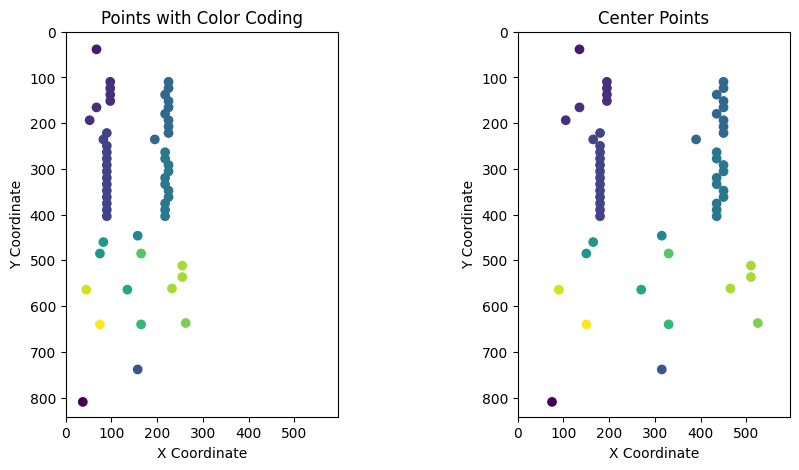

In [442]:
# Extract x and y coordinates from the test list
x_coords = [point[0] for point in test]
y_coords = [point[1] for point in test]

# Extract color codes from the test list
colors = [point[2] for point in test]


# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first subplot with test data
ax1.scatter(x_coords, y_coords, c=colors)
ax1.set_xlabel('X Coordinate')
ax1.set_ylabel('Y Coordinate')
ax1.set_title('Points with Color Coding')
ax1.axis('scaled')
ax1.set_xlim(0, page_dict['width'])
ax1.set_ylim(0, page_dict['height'])
ax1.invert_yaxis()  # Reverse the y-axis

# Extract x and y coordinates from the center_points list
center_x_coords = [point[0] for point in center_points]
center_y_coords = [point[1] for point in center_points]

# Plot the second subplot with center_points data
ax2.scatter(center_x_coords, center_y_coords, c=colors)
ax2.set_xlabel('X Coordinate')
ax2.set_ylabel('Y Coordinate')
ax2.set_title('Center Points')
ax2.axis('scaled')
ax2.set_xlim(0, page_dict['width'])
ax2.set_ylim(0, page_dict['height'])
#ax2.set_ylim(page_dict['height'], 0)  # Reverse the y-axis
ax2.invert_yaxis()  # Reverse the y-axis
#ax2.legend()

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Show the plot
plt.show()


In [406]:
test

[[30.0, 809.5, 0],
 [67.5, 38.5, 1],
 [142.5, 121.5, 2],
 [60.0, 778.5, 3],
 [90.0, 207.5, 4],
 [90.0, 235.5, 4],
 [90.0, 249.5, 4],
 [82.5, 263.5, 4],
 [90.0, 277.5, 4],
 [90.0, 291.5, 4],
 [90.0, 305.5, 4],
 [90.0, 319.5, 4],
 [90.0, 333.5, 4],
 [90.0, 347.5, 4],
 [90.0, 361.5, 4],
 [90.0, 375.5, 4],
 [90.0, 389.5, 4],
 [82.5, 403.5, 4],
 [82.5, 431.5, 4],
 [90.0, 445.5, 4],
 [90.0, 459.5, 4],
 [90.0, 473.5, 4],
 [90.0, 487.5, 4],
 [90.0, 501.5, 4],
 [90.0, 515.5, 4],
 [90.0, 529.5, 4],
 [90.0, 543.5, 4],
 [82.5, 557.5, 4],
 [90.0, 571.5, 4],
 [90.0, 585.5, 4],
 [60.0, 599.5, 4],
 [90.0, 627.5, 5],
 [90.0, 641.5, 5],
 [90.0, 655.5, 5],
 [90.0, 669.5, 5],
 [90.0, 683.5, 5],
 [90.0, 697.5, 5],
 [90.0, 711.5, 5],
 [225.0, 207.5, 6],
 [225.0, 221.5, 6],
 [202.5, 235.5, 6],
 [225.0, 263.5, 7],
 [225.0, 277.5, 7],
 [225.0, 291.5, 7],
 [217.5, 305.5, 7],
 [225.0, 319.5, 7],
 [217.5, 333.5, 7],
 [225.0, 347.5, 7],
 [225.0, 361.5, 7],
 [225.0, 375.5, 7],
 [225.0, 389.5, 7],
 [202.5, 403.5, 7]

In [340]:
scaled_points

[(37.5, 809.5),
 (67.5, 38.5),
 (90.0, 389.5),
 (90.0, 403.5),
 (90.0, 431.5),
 (90.0, 445.5),
 (90.0, 459.5),
 (90.0, 473.5),
 (90.0, 487.5),
 (90.0, 501.5),
 (90.0, 515.5),
 (60.0, 529.5),
 (82.5, 557.5),
 (90.0, 571.5),
 (90.0, 585.5),
 (90.0, 599.5),
 (37.5, 613.5),
 (90.0, 641.5),
 (90.0, 655.5),
 (82.5, 669.5),
 (82.5, 683.5),
 (45.0, 783.5),
 (217.5, 585.5),
 (217.5, 599.5),
 (225.0, 613.5),
 (217.5, 627.5),
 (225.0, 641.5),
 (217.5, 655.5),
 (225.0, 669.5),
 (202.5, 683.5),
 (135.0, 110.0),
 (105.0, 140.0),
 (105.0, 343.0),
 (270.0, 137.0),
 (270.0, 345.0),
 (45.0, 176.0),
 (45.0, 221.5),
 (45.0, 266.5),
 (45.0, 312.5),
 (157.5, 175.5),
 (157.5, 221.0),
 (157.5, 266.0),
 (157.5, 311.5),
 (270.0, 221.5),
 (270.0, 266.5),
 (45.0, 288.0),
 (120.0, 190.0),
 (142.5, 257.0),
 (142.5, 302.0),
 (232.5, 418.0),
 (210.0, 434.5),
 (210.0, 457.0),
 (232.5, 497.0),
 (247.5, 434.5),
 (210.0, 474.5),
 (225.0, 514.5),
 (240.0, 457.5),
 (240.0, 536.5),
 (195.0, 497.5),
 (210.0, 536.5),
 (225.0,

In [270]:
labels

array([0, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6])

In [271]:
len(page_blocks)

43

In [341]:
for b in page_blocks:
    for l in b["lines"]:
        for s in l["spans"]:
            if b.get('cluster') == 0:
                print(s["text"])

12
6 
Snider 2017


In [342]:
for b in page_blocks:
    for l in b["lines"]:
        for s in l["spans"]:
            if b.get('cluster') == 1:
                print(s["text"])

M A S C H I N E L L E S  L E R N E N


In [343]:
for b in page_blocks:
    for l in b["lines"]:
        for s in l["spans"]:
            if b.get('cluster') == 2:
                print(s["text"])

vor kamen, gut funktioniert. Außerdem sollen die Modelle ro-
bust sein, also auf ähnliche Eingaben auch ähnlich reagieren. 
Die Qualität eines Modells hängt auch von der Qualität der 
Trainingsdaten ab. Werden dem Algorithmus zu viele falsche 
Beispiele gezeigt, kann er nicht die korrekten Antworten 
lernen. Wenn die Beispiele nicht repräsentativ sind, sind die 
Ausgaben bei neuartigen Eingaben auch mit größerer Un-
sicherheit behaftet. Manche Modelle können aber zusammen 
mit ihrer Ausgabe auch eine Einschätzung abliefern, wie 
fundiert die Ausgabe ist. 


In [344]:
for b in page_blocks:
    for l in b["lines"]:
        for s in l["spans"]:
            if b.get('cluster') == 3:
                print(s["text"])

Eine wünschenswerte und wichtige Eigenschaft ist die 
Nachvollziehbarkeit der Modelle im Allgemeinen und ihrer 
Ergebnisse im Einzelfall. Entscheidungsbäume lassen sich 
besonders gut interpretieren, tiefe Neuronale Netze hingegen 


In [345]:
for b in page_blocks:
    for l in b["lines"]:
        for s in l["spans"]:
            if b.get('cluster') == 4:
                print(s["text"])

schlecht.


In [346]:
for b in page_blocks:
    for l in b["lines"]:
        for s in l["spans"]:
            if b.get('cluster') == 5:
                print(s["text"])

Die gute Skalierbarkeit mit steigenden Datenmengen einer- 
seits und die schlechte Nachvollziehbarkeit andererseits sind 
Gründe, weshalb die im Projekt konsultierten Fachleute 
das tiefe Lernen für notwendig, aber nicht ausreichend 


In [348]:
for b in page_blocks:
    for l in b["lines"]:
        for s in l["spans"]:
            if b.get('cluster') == 7:
                print(s["text"])

Abbildung 2: Schematische Darstellung eines KNN, hier in Form eines Feed-forward Network – eigene Darstellung


In [124]:
pdf_address = "a.pdf"
doc = fitz.open(pdf_address)
page = doc.load_page(9)
page_dict = page.get_text("dict")
page_blocks = page_dict["blocks"]

In [125]:
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist, squareform

# Sample data: list of dictionaries with bounding boxes
data = page_blocks

def get_center(bbox):
    x0, y0, x1, y1 = bbox
    return ((x0 + x1) / 2, (y0 + y1) / 2)

# Custom distance function for bounding boxes
def bbox_distance(bbox1, bbox2, x_threshold, y_threshold):
    center1 = get_center(bbox1)
    center2 = get_center(bbox2)

    # Calculate distances in x and y separately
    x_dist = abs(center1[0] - center2[0])
    y_dist = abs(center1[1] - center2[1])

    # Check if distances are within the specified thresholds
    if x_dist <= x_threshold and y_dist <= y_threshold:
        return 0  # Considered as 'close enough'
    else:
        return 1  # Considered as 'not close enough'

# Parameters for the custom distance function
x_threshold = 250  # Example threshold for x-axis
y_threshold = 100  # Example threshold for y-axis

# Extract bounding boxes from the data
bboxes = [line['bbox'] for item in data for line in item['lines']]

# Compute the distance matrix
dist_matrix = pdist(bboxes, lambda u, v: bbox_distance(u, v, x_threshold, y_threshold))

# Hierarchical clustering
Z = linkage(squareform(dist_matrix), method='complete')

# Forming clusters
max_d = 0.5  # Maximum distance for two points to be in the same cluster
clusters = fcluster(Z, max_d, criterion='distance')

# Assign each line to a cluster
for i, item in enumerate(data):
    for j, line in enumerate(item['lines']):
        line['cluster'] = clusters[i * len(item['lines']) + j]

# Now, each line in your data has a 'cluster' key indicating its cluster.


/tmp/ipykernel_288540/112358985.py:38: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(squareform(dist_matrix), method='complete')


In [126]:
clusters

array([ 8, 12,  9, 10, 11,  7,  7,  7,  7, 27, 28, 33, 35, 34, 36, 31, 29,
       30, 32,  4,  5,  3,  1,  2, 42, 40, 41, 38, 39, 45, 43, 44, 46, 73,
       71, 75, 74, 58, 59, 56, 57, 53, 54, 55, 21, 22, 37, 23, 19, 20, 25,
       24, 26, 17, 15, 16, 18,  6, 13, 14, 51, 50, 52, 48, 49, 47, 69, 72,
       70, 68, 66, 63, 67, 65, 64, 62, 60, 61], dtype=int32)

In [127]:
page_blocks

[{'number': 0,
  'type': 0,
  'bbox': (68.03150177001953,
   805.250244140625,
   73.0354995727539,
   814.250244140625),
  'lines': [{'spans': [{'size': 9.0,
      'flags': 4,
      'font': 'FrutigerLTCom-Roman',
      'color': 0,
      'ascender': 0.75,
      'descender': -0.25,
      'text': '8',
      'origin': (68.03150177001953, 812.000244140625),
      'bbox': (68.03150177001953,
       805.250244140625,
       73.0354995727539,
       814.250244140625)}],
    'wmode': 0,
    'dir': (1.0, 0.0),
    'bbox': (68.03150177001953,
     805.250244140625,
     73.0354995727539,
     814.250244140625),
    'cluster': 8}]},
 {'number': 1,
  'type': 0,
  'bbox': (68.03150177001953,
   34.0159912109375,
   204.282470703125,
   43.0159912109375),
  'lines': [{'spans': [{'size': 9.0,
      'flags': 4,
      'font': 'FrutigerLTCom-Light',
      'color': 0,
      'ascender': 0.75,
      'descender': -0.25,
      'text': 'M A S C H I N E L L E S  L E R N E N',
      'origin': (68.03150177001953